<a href="https://colab.research.google.com/github/willdphan/fashion-cnn/blob/main/CNN_Fashion_Classifier_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [ ]:
# preprocessing step in ml tasks that involve images. converts images into tensors
# to allows us to convert image data compatible by ml models
transform = transforms.ToTensor()
# defines the number of examples processed in a single iteration
batch_size = 8

# initializes the data set and shows training process. 
# Downloads the data set from internet
# Transform converts the image data to PyTorch tensors 
# and scales the pixel values from [0, 255] to [0, 1]
# images are typically represented as integers in the range [0, 255]
# THIS IS THE TRAINSET
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

# initializes the data set and does not show training process
# Downloads the data set from internet
# Transfroms converts the image data to PyTorch tensors 
# and scales the pixel values from [0, 255] to [0, 1]
# THIS IS THE TESTSET
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

# both above datasets are used to train and evaluate the
# performance of the deep learning model, respectively.

# Each image in the dataset is assigned a label that corresponds to one of 
# these 10 classes, and during training, the deep learning model learns to 
# predict the correct label for each image
classes = ('T-shirt/top', 'Trouser/pants','Pullover shirt','Dress','Coat','Sandal',
           'Shirt','Sneaker','Bag','Ankle boot')

In [ ]:
# creates the iterator for the trainset data. Iterates over elements of a dataset
train_iter = iter(trainset)
# next() fetches items for iterator. When called, it advances the iterator to 
# the next element and returns the element. image and label are assigned values to be returned
image, label = next(train_iter)
# return the shape of the tensor as a tuple, and the number of labels
image.shape, label

(torch.Size([1, 28, 28]), 9)

In [ ]:
# returns the min and max value in the image tensor
# By calling .item() on each of these tensors, we convert them to Python integers, 
# which allows us to print them as part of a string using the print() function
torch.min(image).item(), torch.max(image).item()

(0.0, 1.0)

Ankle boot


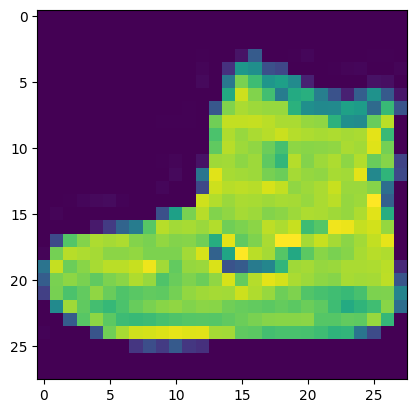

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# converts image tensor to numpy array
np_img = image.numpy()
# prints class label of image
print(classes[label])
# displays image using matplotlib
# reshape, reshapes numpy array into 28x28x1, the required shape to display greyscale
# images in matplotlib
plt.imshow(np_img.reshape((28, 28, 1)))

In [ ]:
# print the (length) of samples in the training and dataset
len(trainset), len(testset)

(60000, 10000)

In [ ]:
# splits the training set into a 50,000 training set and a validation set with 10,000 samples
trainset, valset = torch.utils.data.random_split(trainset, [50000, 10000])
# then prints the lengths of these samples
# remaining testset (10,000) is used for eval the model on unseen data
len(trainset), len(valset), len(testset)

(50000, 10000, 10000)

In [ ]:
print(f'Number of batches in the training set: {int(50000 / batch_size)}')

Number of batches in the training set: 6250


In [ ]:
print(f'Number of batches in the validation set: {int(10000 / batch_size)}')

Number of batches in the validation set: 1250


In [ ]:
# returns the trainset object
type(trainset)

torch.utils.data.dataset.Subset

In [ ]:
# creates data loaders for the three sets which provides batches of data as you iterate over
# during training or evaluation
# data is fixed in val and test for unbiased estimates.
# The num_workers argument specifies the number of worker threads to use

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# NN Model
class NeuralNet(nn.Module):
    # tells network what it has
    def __init__(self):
        super().__init__()
        # first conv layer
        # in_channels = 1 bcuz grey scale imgs
        # out_channels = 256 bcuz we convert 1 into 256 depth (filters)
        # kernal_size = 3 for a 3x3 window, image converted to 26x26x1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3)
        # often accompanies conv layer.
        # takes 2x2 windows and take the max value of those
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.pool3 = nn.MaxPool2d(2, 2)


        # make the long skinny image into a super long vector - flatten it out
        self.flatten = nn.Flatten()

        # linear layers transforms data
        # in_features = 4069, stretched out vector
        # out_features = 1024 vectors, a smaller power of 2
        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        # give values a 30% to dropout, great for overfitting problem
        self.drop1 = nn.Dropout(p=0.3)

        # below adds one more linear dropout combinations
        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.drop2 = nn.Dropout(p=0.3)
        
        # add output layer with no dropout and end in 10 values bcuz 
        self.out = nn.Linear(in_features=1024, out_features=10)

    # this function invokes the layers above. Runs batch of images thru (X) 
    # convo layer
    # Tells network how it works
    # takes 'self' to access the layers and 'x' which is basically whatever 
    # you're throwing in it (batch of images in this case)
    def forward(self, x):
      # runs 'x' thru the conv1 layer
      x = F.relu(self.conv1(x))
      # runs 'x' thru the pool
      x = self.pool1(x)

      x = F.relu(self.conv2(x))
      x = self.pool2(x)

      x = F.relu(self.conv3(x))
      x = self.pool3(x)

      x = self.flatten(x)

      x = F.relu(self.fc1(x))
      x = self.drop1(x)

      x = F.relu(self.fc2(x))
      x = self.drop2(x)

      x = self.out(x)

      # returns tensor
      return x

In [ ]:
# declare the 'net' class
net = NeuralNet()
# moves the network to the appropriate device - CPU or GPU
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
for i, data in enumerate(trainloader):
    # unpacks the data tuple 
    inputs, labels = data[0].to(device), data[1].to(device)
    # shows the shape of images before it goes into network
    print(f'input shape: {inputs.shape}')
    # shows the shape of images after it goes into network
    print(f'after network shape: {net(inputs).shape}')
    break

input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])


In [ ]:
num_params = 0
# iterate thru number of params and get total # params
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 8,536,074


In [ ]:
import torch.optim as optim

# if u don't end in a softmax
criterion = nn.CrossEntropyLoss()
# pass in out params and learning rate
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [ ]:
# train for 1 epoch
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  # iterate over trainloader, each time you do, you get batch_index and data
  # enumerating over the trainloader
  for batch_index, data in enumerate(trainloader):
    # we need imputs and labels, move each to our device (CPU or GPU)
    inputs, labels = data[0].to(device), data[1].to(device)

    # for a non-zero values for gradients, set them to zero to reset
    optimizer.zero_grad()

    # run inputs thru a network
    outputs = net(inputs) # shape: [batch_size, 10]
    # calc number of correct predictions we got is the where the torch.sum of 
    # the labels == our model predictions. It sums up the ones we got right
    # then take the item and turn it into an integer between 0-8 how how many 
    # images the model go right for that batch
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    # get accuracy
    running_accuracy += correct / batch_size

    # loss value is the criterion - where it compares the outputs (predictions)
    # to the labels (ground-truth)
    loss = criterion(outputs, labels)
    # whatever the loss is, keep track of it and add it to the runing_loss var
    running_loss += loss.item()
    # go thru the loss tensor and go thru model params and calculate gradients
    loss.backward()
    # takes a step and optimizes the model a little better to make the loss
    # less on the next batch it receives
    optimizer.step()

    # every 500 batch
    if batch_index % 500 == 499:  # print every 500 batches
      # We get the average loss and divide by 500.
      avg_loss_across_batches = running_loss / 500
      # We get the average accuracy and divide by 500 and mult 100 so its not a
      # fraction
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      # Important, set both back to zero to avoid going higher than 100%
      running_loss = 0.0
      running_accuracy = 0.0

  print()

In [ ]:
# validate
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    # iterate through the validation loader
    for i, data in enumerate(valloader):
        # get images and labels batches
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # don't worry ab the gradients, bcuz we are not training model
        with torch.no_grad(): 
            # same thing as before get everything except getting grads
            outputs = net(inputs) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, average batch loss
            running_loss += loss.item()
    
    # calc average loss across batches. Val loader calculated above
    avg_loss_across_batches = running_loss / len(valloader)
    # calc average accuracy across batches x 100. Val loader calculated above
    avg_acc_across_batches = (running_accuracy / len(valloader)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [ ]:
# training loop
# run thru 6250 batch of 8 images (1 training set) ten times
num_epochs = 10

# loop through 10 times (range(10))
for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    # train, each time we see a batch, we update the model
    train_one_epoch()
    # valuate the perfomance of the model on new data
    validate_one_epoch()
        
print('Finished Training')

Epoch: 1

Batch 500, Loss: 1.185, Accuracy: 54.6%
Batch 1000, Loss: 0.720, Accuracy: 72.4%
Batch 1500, Loss: 0.649, Accuracy: 75.9%
Batch 2000, Loss: 0.585, Accuracy: 78.5%
Batch 2500, Loss: 0.557, Accuracy: 78.1%
Batch 3000, Loss: 0.507, Accuracy: 81.1%
Batch 3500, Loss: 0.507, Accuracy: 80.7%
Batch 4000, Loss: 0.482, Accuracy: 82.0%
Batch 4500, Loss: 0.465, Accuracy: 83.5%
Batch 5000, Loss: 0.467, Accuracy: 83.0%
Batch 5500, Loss: 0.446, Accuracy: 84.2%
Batch 6000, Loss: 0.425, Accuracy: 83.9%

Val Loss: 0.377, Val Accuracy: 85.8%
***************************************************

Epoch: 2

Batch 500, Loss: 0.386, Accuracy: 85.7%
Batch 1000, Loss: 0.379, Accuracy: 86.2%
Batch 1500, Loss: 0.382, Accuracy: 85.8%
Batch 2000, Loss: 0.365, Accuracy: 86.9%
Batch 2500, Loss: 0.355, Accuracy: 87.2%
Batch 3000, Loss: 0.370, Accuracy: 86.2%
Batch 3500, Loss: 0.341, Accuracy: 87.9%
Batch 4000, Loss: 0.328, Accuracy: 88.3%
Batch 4500, Loss: 0.334, Accuracy: 88.0%
Batch 5000, Loss: 0.315, Accur